In [14]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as opt
import vegas

In [2]:
# Global constants
# light speed, cm
c = 3*1e10
# kpc to cm
kpc2cm = 3.08*1e21
# erg to MeV
erg2MeV = 624150.913
# year in seconds
yr = 31536000
# Neutrino lumonisity, single specie
Lv = 3e52/6

In [3]:
def dnvdEv(r,Ev,Lv=Lv):
    """
    Neutrino number density per energy at r
    
    Input
    ------
    Enu: Neutrino energy in MeV
    r: Distance to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s, total time is 10 second
    
    Output
    ------
    Neutrino flux at r: # per Enu per cm**3 per second
    """
    Lv = Lv*erg2MeV
    r = r*kpc2cm
    
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    L=Lv/(4*np.pi*r**2*c)
    return L*(nue_dist+nueb_dist+4*nux_dist)

def nx(r,mx,rho,rs,type='MW_r'):
    """
    DM number density at r
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    rho: characteristic density, default is 184 MeV/cm^3
    rs: characteristic length, default is 24.42 kpc
    type: density profile type, like NFW or Hernquist profile
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    x = r/rs
    rho_num = rho/mx
    if type=='MW_r':
        return rho_num/(x*(1+x)**2)
    elif type=='MW':
        return 4488/mx
    elif type=='LMC':
        if x>15.0:
            return 0.
        return rho_num/(x*(1+x)**3)

In [4]:
def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    if np.isnan((Ev + mx)/((mx**2+2*mx*Ev)**0.5)):
        print(Ev,mx,mx**2+2*mx*Ev)
    return (Ev + mx)/((mx**2+2*mx*Ev)**0.5)
def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution
    
    Input
    ------
    Ev: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """
    # From Wen-Hua's note
    if 0 <= alpha <= np.pi/2 and Ev>0: 
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
        return dndOmega
    else:
        """gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2"""
        return 0

def Tx(Ev,mx,alpha):
    """
    Calculate DM kinetic energy, Eq. (28), and velocity, Eq. (30),
    in terms of lab frame scattering angle
    
    Input
    ------
    Ev: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    Tx: DM kinetic energy at alpha after scattering
    """
    # gamma factor in CM frame
    gm = gamma(Ev,mx)
    # CM frame scattering angle
    theta_c = 2*np.arctan(gm*np.tan(alpha))
    
    # Tmax in lab frame
    Tmax = Ev**2/(Ev+0.5*mx)
    Tchi = 0.5*Tmax*(1+np.cos(theta_c))
    return Tchi


def Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame scattering angle alpha via analytical expression.
    Note that if Ev is negative then it is unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """
    sec = 1/np.cos(alpha)
    enu = (Tx*sec**2 + sec*np.sqrt(Tx*(2*mx + Tx)))/(2 - Tx*np.tan(alpha)**2/mx)
    return enu


def dEvdTx(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    dTx: arbitrarity small number, default 1e-5
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def vx(Tx,mx):
    """
    The dimensionless DM velocity. To restore the physical unit, just
    times the speed of light c
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    
    Output
    ------
    vx: dimensionless DM velocity
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)

def xemissivity(Tx,mx,alpha,r,rho=184,rs=24.42,Lv=Lv):
    """
    Upscattered DM emissivity, note the returned result is divided by sigxv and light velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    vx: the DM dimensionless velocity in terms of Tx and mx
    r: the distance from the scattering point to GC, kpc
    rho: DM halo characteristic density, default 184 MeV/cm^3
    rs: DM halo characteristic length, default 24.42 kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    Enu = Ev(Tx,mx,alpha)
    
    if alpha!=0.:
        if Tx < 2*mx/np.tan(alpha)**2 and Enu >= 0:    
            dEdT = dEvdTx(Tx,mx,alpha)
            jx = dnvdEv(r,Enu,Lv)*c *nx(r,mx,rho,rs)*g(Enu,mx,alpha)*dEdT
        else:
            jx = 0
    else:
        jx = 0
    return jx

In [5]:
def Root_Finding(theta, t,vx,R = 8.5,r_cut=0.001):
    """
    Find l, r and alpha when t, cos\theta, R and vx are given
    
    Input
    ------
    t: timing in seconds, 0 starts from the first arrival of the SN neutrino at Earth
    theta: in rad
    vx: dimensionless DM velocity, v/c
    R: R in kpc, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    tuple: (l,r,alpha,flag)
           flag is a string label, physical/unphysical, where unphysical
           result should be considered zero contribution to the emissivity
    """
    cos = np.cos(theta)
    zeta = c*t/kpc2cm + R
    k = zeta/R
    l = (-2*zeta*vx+2*cos*R*vx**2 + np.sqrt(vx**2*(2*zeta-2*cos*R*vx)**2 + 4*(-R**2+zeta**2)*vx**2*(-1+vx**2)))/(2*(-1+vx**2))
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vx-1)
    
    r = 0.0
    if l**2 + R**2 - 2*l*R*cos<0.:
        r = 0.0
    else:
        r = np.sqrt(l**2 + R**2 - 2*l*R*cos)
    
    alpha = 0.0

    if r>0 and l>0.:
        if (R**2-r**2-l**2)/(2*r*l)>1.0:
            alpha = 0.0
        elif (R**2-r**2-l**2)/(2*r*l)<-1.0:
            alpha = np.pi
        else:
            alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
        if(np.isnan(alpha)):
            print(r,l,(R**2-r**2-l**2)/(2*r*l))
    else:
        alpha = 0.0
    # Avoid Unphysical Geometry

    if l > 0 and r > 0 and r > r_cut and 0 <= alpha <= 0.5*np.pi:
        flag = 'physical'
    else:
        flag = 'unphysical'

    return l,r,alpha,flag

In [6]:
def bdmflux(t,Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.001):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """

    # find DM velocity
    beta = vx(Tx,mx)

    def f(theta): 
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R,r_cut) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    
    result = integrate.quad(f,0.1,np.pi/2)[0]
    result += integrate.quad(f,0.01,0.1)[0]
    result += integrate.quad(f,0.001,0.01)[0]
    result += integrate.quad(f,0.0001,0.001)[0]
    result += integrate.quad(f,0.00001,0.0001)[0]
    result += integrate.quad(f,1e-6,0.00001)[0]
    result += integrate.quad(f,0,1e-6)[0]
    
    return result*beta*c

In [7]:
def Jacobian_Quad(f,a,b):
  ua = np.log(a)
  ub = np.log(b)
  def s(z):
    return f(np.exp(z))*np.exp(z)
  return integrate.quad(s,ua,ub)[0]
def Get_Theta_Crit(f,a,b):
  thetas = np.logspace(np.log10(a),np.log10(b),10)
  fs = []
  for i in range(len(thetas)):
    fs.append(f(thetas[i]))
  idx = np.argmax(fs)
  return thetas[idx]

def bdmflux_new(t,Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.001):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    #rf = R/c
    #ts = (c*t+R)/R
    #rs_in_rf = rs/R
    
    # find DM velocity
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)

    def f(theta): 
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R,r_cut) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    theta_crit = Get_Theta_Crit(f,1e-8,np.pi/2.)
    result = Jacobian_Quad(f,theta_crit,np.pi/2)
    result += Jacobian_Quad(f,0.1*theta_crit,theta_crit)
    result += integrate.quad(f,0.,0.1*theta_crit)[0]

    return result*beta*c

In [15]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx1 = 5
#Tx2 = 50
# years
yrls=np.logspace(-6,3,1000)

fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux_new(y*yr,Tx1,mx1,r_cut=0.001))

fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_new(y*yr,Tx1,mx2,r_cut=0.001))

fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux_new(y*yr,Tx1,mx3,r_cut=0.001))

fluxmx4_20=[]
for y in yrls:
    fluxmx4_20.append(bdmflux_new(y*yr,Tx1,mx4,r_cut=0.001))

/tmp/ipykernel_3313/2746431241.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))


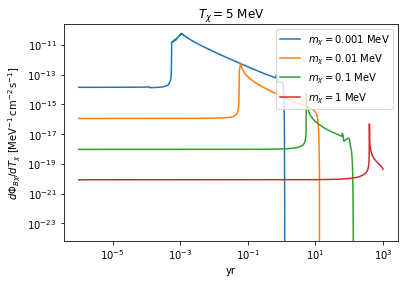

In [16]:
plt.plot(yrls,fluxmx1_20,label='$m_\chi=$' +str(mx1)+' MeV')
plt.plot(yrls,fluxmx2_20,label='$m_\chi=$' +str(mx2)+' MeV')
plt.plot(yrls,fluxmx3_20,label='$m_\chi=$' +str(mx3)+' MeV')
plt.plot(yrls,fluxmx4_20,label='$m_\chi=$' +str(mx4)+' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi_{B\chi}/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx1)+' MeV')
plt.legend(loc='best')
#plt.ylim(1e-21,1e-9)
#plt.savefig('time_dependent_flux_20MeV_2.pdf',facecolor='white',bbox_inches='tight')
plt.show()

In [17]:
def Vegas_Jacobian_Integration(f,a,b):
    ua = np.log(a)
    ub = np.log(b)
    def fg(z):
        return f([np.exp(z[0])])*np.exp(z[0])
    integ = vegas.Integrator([[ua, ub]])
    result = integ(fg, nitn=1, neval=1000)

    return result.mean

def bdmflux_vegas(t,Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.001):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    #rf = R/c
    #ts = (c*t+R)/R
    #rs_in_rf = rs/R
    
    # find DM velocity
    beta = vx(Tx,mx)

    def f(theta): 
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta[0],t,beta,R,r_cut=r_cut) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta[0]) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        
        physical_terms /= (l-R*np.cos(theta[0]))/r*beta+1
        
        return geometric_terms*physical_terms
    def Get_Theta_Crit_Vegas(f,a,b):
        thetas = np.logspace(np.log10(a),np.log10(b),10)
        fs = []
        for i in range(len(thetas)):
            fs.append(f([thetas[i]]))
        idx = np.argmax(fs)
        return thetas[idx]
    theta_crit = Get_Theta_Crit_Vegas(f,1e-8,np.pi/2.)
    result = Vegas_Jacobian_Integration(f,theta_crit, np.pi/2.)
    result = Vegas_Jacobian_Integration(f,1e-8, theta_crit)
    return result*beta*c


In [ ]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx1 = 5
#Tx2 = 50
# years
yrls=np.logspace(-6,3,1000)

fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux_vegas(y*yr,Tx1,mx1,r_cut=0.01))

fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_vegas(y*yr,Tx1,mx2,r_cut=0.01))
    
fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux_vegas(y*yr,Tx1,mx3,r_cut=0.01))

fluxmx4_20=[]
for y in yrls:
    fluxmx4_20.append(bdmflux_vegas(y*yr,Tx1,mx4,r_cut=0.01))

/tmp/ipykernel_3313/2746431241.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))


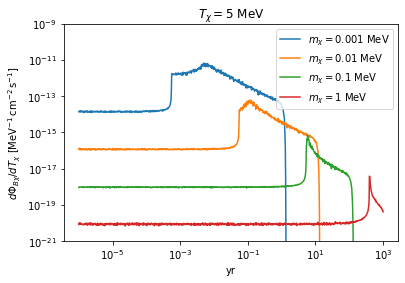

In [15]:
plt.plot(yrls,fluxmx1_20,label='$m_\chi=$'+str(mx1)+' MeV')
plt.plot(yrls,fluxmx2_20,label='$m_\chi=$' +str(mx2)+' MeV')
plt.plot(yrls,fluxmx3_20,label='$m_\chi=$' +str(mx3)+' MeV')
plt.plot(yrls,fluxmx4_20,label='$m_\chi=$' +str(mx4)+' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi_{B\chi}/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx1)+' MeV')
plt.legend(loc='best')
plt.ylim(1e-21,1e-9)
#plt.savefig('time_dependent_flux_20MeV_2.pdf',facecolor='white',bbox_inches='tight')
plt.show()

In [16]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx1 = 5
#Tx2 = 50
# years
yrls=np.logspace(-6,3,1000)

fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux_vegas(y*yr,Tx1,mx1,r_cut=0.01))
fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_vegas(y*yr,Tx1,mx1,r_cut=0.00))

/tmp/ipykernel_6456/3671157136.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))


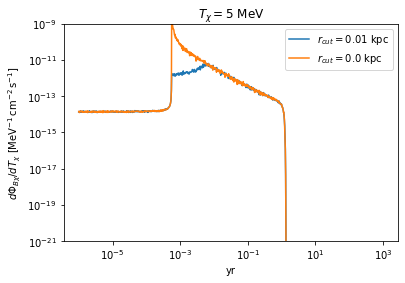

In [21]:
plt.plot(yrls,fluxmx1_20,label='$r_{cut}=$'+str(0.01)+' kpc')
plt.plot(yrls,fluxmx2_20,label='$r_{cut}=$' +str(0.0)+' kpc')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi_{B\chi}/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx1)+' MeV')
plt.legend(loc='best')
plt.ylim(1e-21,1e-9)
#plt.savefig('time_dependent_flux_20MeV_2.pdf',facecolor='white',bbox_inches='tight')
plt.show()

In [76]:
def Jacobian_Method(func,a,b,n):
  
  def gp(z):
    return func(np.exp(z))
  def Jacobian_Simpson_Method(func,a,b,n):
    dx = (b-a)/n
    sum = 0
    for i in range(n):
      sum += (func(a+i*dx) + 4*func(a+(i+1/2)*dx) + func(a+(i+1)*dx))/6*dx *np.exp(a+(i+1/2)*dx)
    return sum
  sum = Jacobian_Simpson_Method(gp,np.log(a),np.log(b),n)
  return sum
def Jacobian_dblQuad(f,a,b,c,d):
  ua = np.log(a)
  ub = np.log(b)
  uc = np.log(c)
  ud = np.log(d)
  def s(u,v):
    return f(np.exp(u),np.exp(v))*np.exp(u)*np.exp(v)
  return integrate.dblquad(s, uc, ud, lambda x: ua, lambda x: ub)[0]
def Special_dblQuad(f,theta1,theta2,t1,t2):
  utheta1 = np.log(theta1)
  utheta2 = np.log(theta2)
  ut1 = np.log(t1)
  ut2 = np.log(t2)
  
  def s(u,v):
    return f(np.exp(u),np.exp(v))*np.exp(u)*np.exp(v)
  def Get_Theta_at_T(ut):
    t = np.exp(ut)
    thetas = np.logspace(-8,np.log10(np.pi/2.),10)
    fs = []
    for i in range(len(thetas)):
      fs.append(f(thetas[i],t))
    idx = np.argmax(fs)
    return np.log(thetas[idx])
  
  result = integrate.dblquad(s, ut1, ut2, lambda ut: Get_Theta_at_T(ut), lambda ut: utheta2)[0]
  result += integrate.dblquad(s, ut1, ut2, lambda ut: Get_Theta_at_T(ut)-np.log(10), lambda ut: Get_Theta_at_T(ut))[0]
  result += integrate.dblquad(f, t1, t2, lambda ut: 0., lambda ut: np.exp(Get_Theta_at_T(ut)-np.log(10)))[0]
  return result
def Vegas_Jacobian_dblIntegration(f,a,b,c,d):
    ua = np.log(a)
    ub = np.log(b)
    uc = np.log(c)
    ud = np.log(d)
    def g(z):
        return f([np.exp(z[0]),np.exp(z[1])])*np.exp(z[0])*np.exp(z[1])
    integ = vegas.Integrator([[ua, ub],[uc, ud]])
    result = integ(g, nitn=1, neval=10000)
    return result.mean
def Accumulated_bdmnumber(Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.001):
    def f(t):
        return bdmflux(t,Tx,mx,tau,sigxv,rho,rs,Lv,R,r_cut)
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vdm-1)
    tmax = np.min([t_crit*10**(1-np.log10(mx)),30*yr])
    return integrate.quad(f,0,tmax)[0]


def Accumulated_bdmnumber_new(Tx,mx,sigxv=1e-45,tau=10,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.001):
    
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)
    tmax = t_crit*10**(1-np.log10(mx))
    def f(theta,t): 
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R) # solve geometry     
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    #return (Jacobian_dblQuad(f,1e-8,np.pi/2.,t_crit*1e-3,tmax))*beta*c
    return (Special_dblQuad(f,1e-8,np.pi/2.,t_crit*1e-3,tmax))*beta*c

def Accumulated_bdmnumber_vegas(Tx,mx,sigxv=1e-45,tau=10,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.001):
    
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)
    tmax = t_crit*10**(1-np.log10(mx))
    def f(para):
        theta = para[0]
        t     = para[1]
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    
    result = Vegas_Jacobian_dblIntegration(f,1e-5,np.pi/2.,t_crit,tmax)
    result += Vegas_Jacobian_dblIntegration(f,1e-8,1e-5,t_crit,tmax)
    result += Vegas_Jacobian_dblIntegration(f,1e-5,np.pi/2.,t_crit*1e-3,t_crit)
    result += Vegas_Jacobian_dblIntegration(f,1e-8,1e-5,t_crit*1e-3,t_crit)

    return result*beta*c


/tmp/ipykernel_2618/4149479579.py:24: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
/tmp/ipykernel_2618/4149479579.py:24: RuntimeWarning: invalid value encountered in arccos
  alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
/tmp/ipykernel_2618/1539276463.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  if Tx < 2*mx/np.tan(alpha)**2 and Enu >= 0:
/tmp/ipykernel_2618/4149479579.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
/tmp/ipykernel_2618/3215743845.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))
/tmp/ipykernel_2618/3370992271.py:30: RuntimeWarning: overflow encountered in exp
  t = np.exp(ut)
/tmp/ipykernel_2618/4149479579.py:22: RuntimeWarning: invalid value encountered in double_scalars
  l = (-2*zeta*vx+2*cos*R*vx**2 + np.sqrt(vx**2*(2*zeta-2*cos*R*vx)**2 + 4*(-R**2+zeta**2

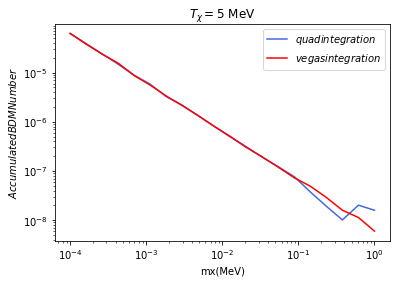

1.0007460184160857


In [80]:

Accumulated_BDMflux_new = []
Accumulated_BDMflux_vegas = []

mx=np.logspace(-4,0,20)
Tx = 5
for i in range(len(mx)):
    Accumulated_BDMflux_new.append(Accumulated_bdmnumber_new(Tx,mx[i]))
    Accumulated_BDMflux_vegas.append(Accumulated_bdmnumber_vegas(Tx,mx[i]))
    
plt.plot(mx,Accumulated_BDMflux_new,color='royalblue',label='$quad integration$')
plt.plot(mx,Accumulated_BDMflux_vegas,color='red',label='$vegas integration$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.title(r'$T_\chi =$'+str(Tx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('mx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()
print(Accumulated_BDMflux_new[0]/Accumulated_BDMflux_vegas[0])

/tmp/ipykernel_2618/4149479579.py:24: RuntimeWarning: invalid value encountered in arccos
  alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
/tmp/ipykernel_2618/1539276463.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  if Tx < 2*mx/np.tan(alpha)**2 and Enu >= 0:
/tmp/ipykernel_2618/3370992271.py:30: RuntimeWarning: overflow encountered in exp
  t = np.exp(ut)
/tmp/ipykernel_2618/4149479579.py:22: RuntimeWarning: invalid value encountered in double_scalars
  l = (-2*zeta*vx+2*cos*R*vx**2 + np.sqrt(vx**2*(2*zeta-2*cos*R*vx)**2 + 4*(-R**2+zeta**2)*vx**2*(-1+vx**2)))/(2*(-1+vx**2))
/tmp/ipykernel_2618/4149479579.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))


0


/tmp/ipykernel_2618/4149479579.py:24: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
/tmp/ipykernel_2618/3215743845.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))


1
2


/tmp/ipykernel_2618/4149479579.py:23: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(l**2 + R**2 - 2*l*R*cos)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/tmp/ipykernel_2618/4149479579.py:22: RuntimeWarning: invalid value encountered in sqrt
  l = (-2*zeta*vx+2*cos*R*vx**2 + np.sqrt(vx**2*(2*zeta-2*cos*R*vx)**2 + 4*(-R**2+zeta**2)*vx**2*(-1+vx**2)))/(2*(-1+vx**2))


30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


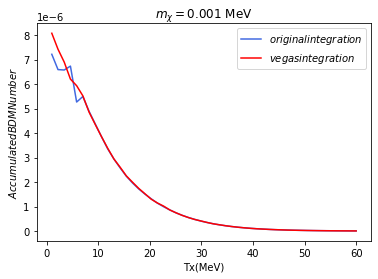

In [78]:
Accumulated_BDMflux = []
Accumulated_BDMflux_vegas = []

Tx=np.linspace(1,60,50)
mx = 1e-3

for i in range(len(Tx)):
  Accumulated_BDMflux.append(Accumulated_bdmnumber_new(Tx[i],mx))
  Accumulated_BDMflux_vegas.append(Accumulated_bdmnumber_vegas(Tx[i],mx))
  print(i)
plt.plot(Tx,Accumulated_BDMflux,color='royalblue',label='$original integration$')
plt.plot(Tx,Accumulated_BDMflux_vegas,color='red',label='$vegas integration$')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best')
plt.title(r'$m_\chi =$'+str(mx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('Tx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()

In [79]:
print(np.sum(Accumulated_BDMflux))
print(np.sum(Accumulated_BDMflux_vegas))


7.672170385038367e-05
7.898664461715905e-05
